In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

data = pd.read_csv('city_market_tracker.tsv', sep='\t')
data = data.sort_values('period_begin')
# data.info()

# col_names = data.columns.tolist()
# print(col_names)

In [12]:
def lagrange_interpolation(x, y):
    """
    Returns a function that evaluates the Lagrange polynomial defined by given nodes.
    
    Parameters:
    - x_nodes: 1D array-like of interpolation nodes
    - y_nodes: 1D array-like of function values at the nodes
    
    Returns:
    - A function P(x_val) that evaluates the Lagrange polynomial at x_val.
    """
    x_nodes = np.array(x)
    y_nodes = np.array(y)
    n = len(x_nodes)
    
    def P(x_val):
        total = 0
        for j in range(n):
            term = y_nodes[j]
            for i in range(n):
                if i != j:
                    term *= (x_val - x[i]) / (x[j] - x[i])
            total += term
        return total
    
    return P

In [13]:
def plot_city(data, city_name, state_code):
    """
    Plots Cubic Spline and Lagrange interpolation (using Chebyshev nodes) for a given city's 
    median sale price over time.

    Parameters:
    - data: DataFrame containing house pricing data.
    - city_name: String, name of the city to filter and plot.
    - state_code: String, state abbreviation (e.g., 'CO' for Colorado) to disambiguate cities.
    - num_nodes: Number of Chebyshev nodes to use for the Lagrange interpolation.
    """
    # Obtain data for city in a specific state
    city_data = data[(data['city'] == city_name) & (data['state_code'] == state_code)].copy()
    if city_data.empty:
        print(f"No data available for {city_name}, {state_code}.")
        return

    # Convert period_begin to datetime and sort data
    city_data['period_begin'] = pd.to_datetime(city_data['period_begin'])
    city_data = city_data.sort_values('period_begin')

    # Remove duplicate dates by averaging sale prices
    city_data = city_data.groupby('period_begin', as_index=False)['median_sale_price'].mean()

    # Convert dates to numerical format
    x = city_data['period_begin'].map(pd.Timestamp.toordinal).values
    y = city_data['median_sale_price'].values

    # Check if x is strictly increasing
    if np.any(np.diff(x) <= 0):
        print(f"Warning: Non-increasing x values detected in {city_name}, {state_code}. Skipping.")
        return

    # Fit cubic spline interpolation
    cubic_spline = CubicSpline(x, y, bc_type='natural')
    
    # Get the number of entries for Chebyshev Nodes
    num_nodes = len(city_data)

    # Determine number of Chebyshev nodes
    n_nodes = min(num_nodes, len(x))
    a, b = x.min(), x.max()

    # Compute Chebyshev nodes in [a, b]
    k = np.arange(n_nodes)
    cheb_nodes = 0.5*(a + b) + 0.5*(b - a) * np.cos((2*k + 1) / (2*n_nodes) * np.pi)
    
    # Get the corresponding y values at Chebyshev nodes using linear interpolation on the original data
    cheb_values = np.interp(cheb_nodes, x, y)

    # Create Lagrange interpolation function using Chebyshev nodes and their corresponding values
    lagrange_poly = lagrange_interpolation(cheb_nodes, cheb_values)

    # Generate smooth x values for plotting
    x_smooth = np.linspace(a, b, 500)
    y_cubic = cubic_spline(x_smooth)  # Evaluate cubic spline
    # Evaluate Lagrange polynomial at each smooth x value
    y_lagrange = np.array([lagrange_poly(val) for val in x_smooth])

    # Convert smooth x values back to datetime for plotting
    dates_smooth = [pd.Timestamp.fromordinal(int(val)) for val in x_smooth]

    # Plot original data points
    plt.figure(figsize=(12, 6))
    plt.plot(city_data['period_begin'], city_data['median_sale_price'], color='black', marker='o', linestyle='-', linewidth=2, label='Real Data', alpha=0.75)

    # Plot cubic spline
    plt.plot(dates_smooth, y_cubic, color='red', linestyle='--', linewidth=1, label='Cubic Spline Interpolation')

    # Plot Lagrange interpolation (using Chebyshev nodes)
    plt.plot(dates_smooth, y_lagrange, color='blue', linestyle='--', linewidth=1, label=f'Lagrange Interpolation (Chebyshev, n={n_nodes})')

    # Formatting
    plt.xlabel('Year')
    plt.ylabel('Median Sale Price ($)')
    plt.title(f'Comparison of Cubic Spline vs. Lagrange (Chebyshev) Interpolation in {city_name}, {state_code}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()

In [14]:
def plot_city_original(data, city_name, state_code):
    """
    Plots Cubic Spline and plain Lagrange interpolation
    for a given city's median sale price over time.

    Parameters:
    - data: DataFrame containing house pricing data.
    - city_name: String, name of the city to filter and plot.
    - state_code: String, state abbreviation (e.g., 'CO' for Colorado).
    """
    # obtain and sort data
    city_data = data[(data['city'] == city_name) & (data['state_code'] == state_code)].copy()
    if city_data.empty:
        print(f"No data available for {city_name}, {state_code}.")
        return

    city_data['period_begin'] = pd.to_datetime(city_data['period_begin'])
    city_data = (
        city_data
        .sort_values('period_begin')
        .groupby('period_begin', as_index=False)['median_sale_price']
        .mean()
    )

    # Convert to numeric x, y
    x = city_data['period_begin'].map(pd.Timestamp.toordinal).values
    y = city_data['median_sale_price'].values

    if np.any(np.diff(x) <= 0):
        print(f"Warning: Non-increasing x values detected in {city_name}, {state_code}. Skipping.")
        return

    # Cubic spline 
    cubic_spline = CubicSpline(x, y, bc_type='natural')

    # Lagrange
    lagrange_poly = lagrange_interpolation(x, y)

    # Smooth x for plotting
    a, b = x.min(), x.max()
    x_smooth = np.linspace(a, b, 500)
    y_cubic    = cubic_spline(x_smooth)
    y_lagrange = np.array([lagrange_poly(xx) for xx in x_smooth])
    dates_smooth = [pd.Timestamp.fromordinal(int(xx)) for xx in x_smooth]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(city_data['period_begin'], city_data['median_sale_price'], 'o-', color='black', alpha=0.75, linewidth=2, label='Real Data')
    plt.plot(dates_smooth, y_cubic,  '--', linewidth=1, color='red',    label='Cubic Spline')
    plt.plot(dates_smooth, y_lagrange, '--', linewidth=1, color='blue',   label=f'Lagrange')

    plt.xlabel('Year')
    plt.ylabel('Median Sale Price ($)')
    plt.title(f'Cubic Spline vs. Lagrange in {city_name}, {state_code}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

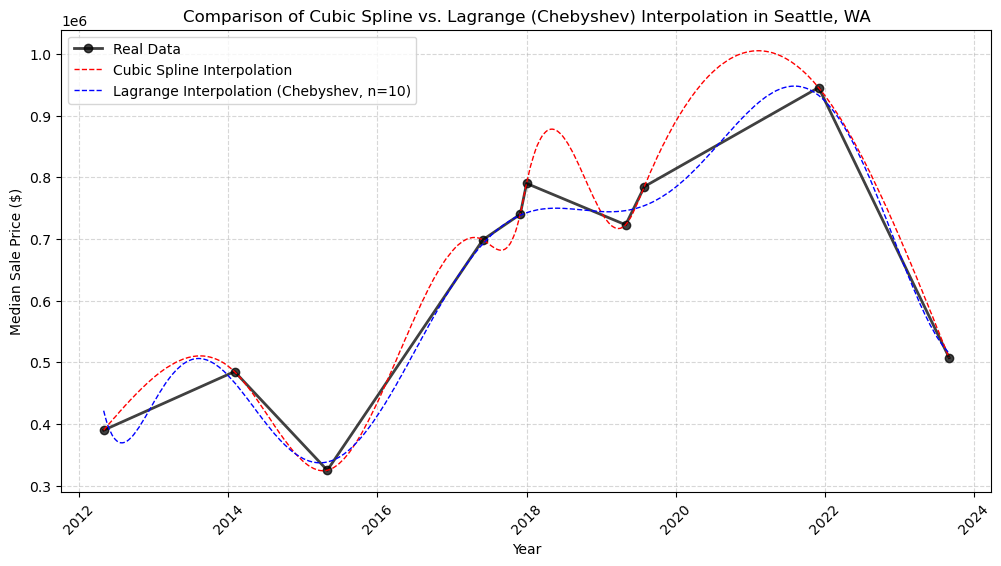

In [15]:
city = 'Seattle'
code = 'WA'

plot_city(data, city, code)
# plot_city_original(data, city, code)

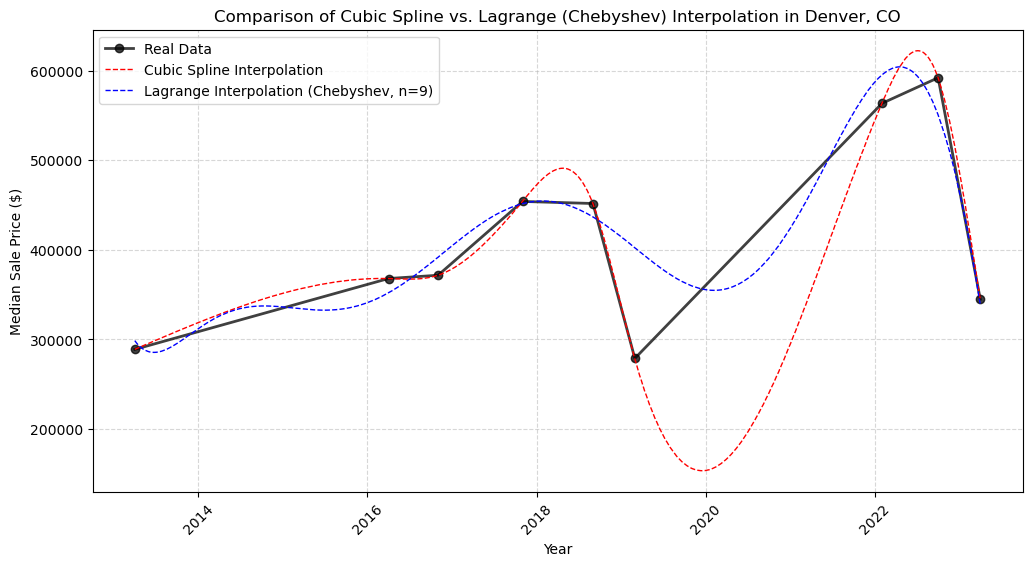

In [16]:
city = 'Denver'
code = 'CO'

plot_city(data, city, code)
# plot_city_original(data, city, code)

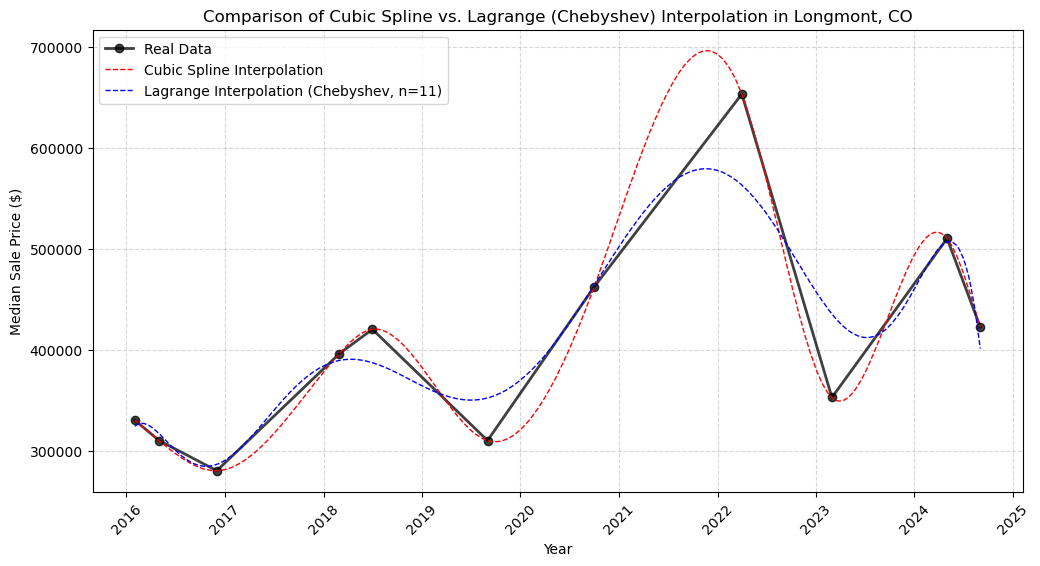

In [18]:
city = 'Longmont'
code = 'CO'

plot_city(data, city, code)
# plot_city_original(data, city, code)

$x^{(0)}_k = \cos(\frac{2k + 1}{2n} \pi)$ for k = 0, 1, ..., n-1

$x_k = \frac{a + b}{2} + \frac{b - a}{2} x^{(0)}_k$